In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics

import pandas as pd
import numpy as np

import math

import re
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

In [3]:
def numericalize(df, col, name):
    if not is_numeric_dtype(col):
        df[name] = col.cat.codes

In [4]:
def fix_missing(df, col, name, nan_dict, is_train):
    
    if is_train:
        if is_numeric_dtype(col):
            if pd.isnull(col).sum():
                df[name+"_na"] = pd.isnull(col)
                nan_dict[name] = col.median()
                df[name] = col.fillna(nan_dict[name])
            
            
    else:
        if is_numeric_dtype(col):
            if name in nan_dict:
                df[name+"_na"] = pd.isnull(col)
                df[name] = col.fillna(nan_dict[name])
                
        
            else:
                df[name] = col.fillna(col.median())

In [5]:
def proc_df(df, y_fld,nan_dict=None,is_train=True):
    
    df = df.copy()
    y = df[y_fld].values
    
    df.drop(y_fld, axis = 1, inplace = True)
    
    if nan_dict is None:
        nan_dict = {}
    
    for n, c in df.items():
        fix_missing(df, c, n,nan_dict, is_train)
        numericalize(df, c, n)
        
    return df, y, nan_dict

In [6]:
df_raw = pd.read_csv("insurance.csv", low_memory=False)

In [7]:
df_raw.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [8]:
df_raw["charges"] = np.log(df_raw.charges)

In [9]:
df_raw["charges"]

0        9.734176
1        7.453302
2        8.400538
3        9.998092
4        8.260197
          ...    
1333     9.268661
1334     7.698927
1335     7.396233
1336     7.604867
1337    10.279914
Name: charges, Length: 1338, dtype: float64

In [10]:
def train_cats(df):
    for n,c in df.items():
        if is_string_dtype(c):
            df[n] = c.astype("category").cat.as_ordered()

In [11]:
def apply_cats(df, train):
    for n, c in df.items():
        if train[n].dtype == "category":
            df[n] = pd.Categorical(c, categories = train[n].cat.categories, ordered = True)

In [12]:
df = df_raw.copy()

In [13]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,9.734176
1,18,male,33.770,1,no,southeast,7.453302
2,28,male,33.000,3,no,southeast,8.400538
3,33,male,22.705,0,no,northwest,9.998092
4,32,male,28.880,0,no,northwest,8.260197


In [14]:
train_cats(df)

In [15]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,9.734176
1,18,male,33.770,1,no,southeast,7.453302
2,28,male,33.000,3,no,southeast,8.400538
3,33,male,22.705,0,no,northwest,9.998092
4,32,male,28.880,0,no,northwest,8.260197


In [16]:
df["region"].cat.categories

Index(['northeast', 'northwest', 'southeast', 'southwest'], dtype='object')

In [17]:
df["region"].cat.codes

0       3
1       2
2       2
3       1
4       1
       ..
1333    1
1334    0
1335    2
1336    3
1337    1
Length: 1338, dtype: int8

In [18]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [19]:
import os

In [20]:
os.makedirs('tmp', exist_ok=True)
df.to_feather('tmp/insurance_1')

## Load in our data from last lesson

In [21]:
df_raw = pd.read_feather('tmp/insurance_1')
df_trn, y_trn, nas = proc_df(df_raw, 'charges')

In [22]:
len(df_raw.columns), df_raw.shape

(7, (1338, 7))

In [23]:
def split_vals(a,n): 
    return a[:n], a[n:]

n_valid = 200
n_trn = len(df_trn)-n_valid
x, x_valid = split_vals(df_trn, n_trn)
y, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(df_raw, n_trn)

In [24]:
raw_train.shape, raw_valid.shape

((1138, 7), (200, 7))

In [25]:
def rmse(x,y): # y_actual - y_predict 
    return math.sqrt(((x-y)**2).mean())


def print_score(m):
    
    print(f"RMSLE of train set {rmse(m.predict(x), y)}")
    print(f"RMSLE of validation set {rmse(m.predict(x_valid), y_valid)}")
    print(f"R^2 of train set {m.score(x, y)}")
    print(f"R^2 of validation set {m.score(x_valid, y_valid)}")

In [26]:
m = RandomForestRegressor()
%time m.fit(x, y)
print_score(m)

Wall time: 327 ms
RMSLE of train set 0.15875936234104257
RMSLE of validation set 0.4012414947841367
R^2 of train set 0.9702179866012206
R^2 of validation set 0.8075025132657199


In [27]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=4, max_features=0.5, n_jobs=-1, oob_score=True, max_depth=7, random_state=42)
%time m.fit(x, y)
print_score(m)

Wall time: 154 ms
RMSLE of train set 0.323111520531804
RMSLE of validation set 0.37730776114957437
R^2 of train set 0.8766383274366711
R^2 of validation set 0.8297822436865113


In [28]:
%time preds = np.array([t.predict(x_valid) for t in m.estimators_])
np.mean(preds[:,0]), np.std(preds[:,0])

Wall time: 25.9 ms


(8.568138543961584, 0.3655253749812599)

In [29]:
x = raw_valid.copy()
x['pred_std'] = np.std(preds, axis=0) 
x['pred'] = np.mean(preds, axis=0) 

In [30]:
x["region"].value_counts()

northwest    55
southwest    50
southeast    49
northeast    46
Name: region, dtype: int64

In [31]:
df_raw["region"].value_counts()

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

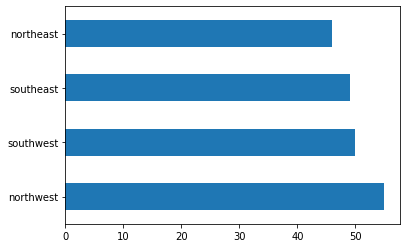

In [32]:
x["region"].value_counts().plot.barh();

In [33]:
fields = ['region', 'charges', 'pred', 'pred_std']
charges_table = x[fields].groupby('region', as_index=True).mean() 
charges_table

,charges,pred,pred_std
region,,,
northeast,9.082910,9.013606,0.280157
northwest,9.053937,9.062161,0.228264
southeast,9.056457,9.070915,0.227744
southwest,9.115526,9.055234,0.262815


In [34]:
fields = ['region', 'charges', 'pred', 'pred_std']
charges_table = x[fields].groupby('region', as_index=False).mean()
charges_table

,region,charges,pred,pred_std
0,northeast,9.082910,9.013606,0.280157
1,northwest,9.053937,9.062161,0.228264
2,southeast,9.056457,9.070915,0.227744
3,southwest,9.115526,9.055234,0.262815


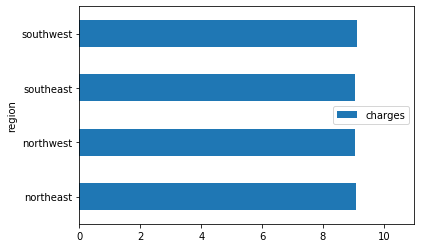

In [35]:
charges_table= charges_table[~pd.isnull(charges_table["charges"])] 
charges_table.plot('region', 'charges', 'barh', xlim=(0,11));

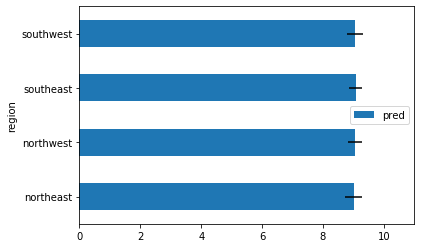

In [36]:
charges_table.plot('region', 'pred', 'barh', xerr='pred_std', xlim=(0,11));

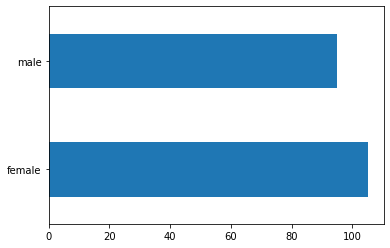

In [37]:
raw_valid["sex"].value_counts().plot.barh();

In [38]:
fields = ['sex', 'charges', 'pred', 'pred_std']
size_table = x[fields].groupby('sex').mean()

In [39]:
size_table

,charges,pred,pred_std
sex,,,
female,8.982653,8.949102,0.260388
male,9.180469,9.164480,0.235802


In [40]:
raw_valid.head()

,age,sex,bmi,children,smoker,region,charges
1138,33,male,30.25,0,no,southeast,8.217264
1139,19,female,32.49,0,yes,northwest,10.515932
1140,50,male,37.07,1,no,southeast,9.110302
1141,41,female,32.60,3,no,southwest,8.981495
1142,52,female,24.86,0,no,southeast,10.207953


In [41]:
(size_table["pred_std"]/size_table["pred"]).sort_values(ascending=False)

sex
female    0.029097
male      0.025730
dtype: float64

In [42]:
(charges_table["pred_std"]/charges_table["pred"]).sort_values(ascending=False)

0    0.031082
3    0.029024
1    0.025189
2    0.025107
dtype: float64

In [43]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'columns':df.columns, 'importance':m.feature_importances_}
                       ).sort_values('importance', ascending=False)

In [44]:
len(m.feature_importances_)

6

In [45]:
m.feature_importances_

array([0.39594459, 0.00640207, 0.05349724, 0.03813531, 0.49309548,
       0.0129253 ])

In [46]:
feature_importance = rf_feat_importance(m, df_trn);

In [47]:
feature_importance

,columns,importance
4,smoker,0.493095
0,age,0.395945
2,bmi,0.053497
3,children,0.038135
5,region,0.012925
1,sex,0.006402


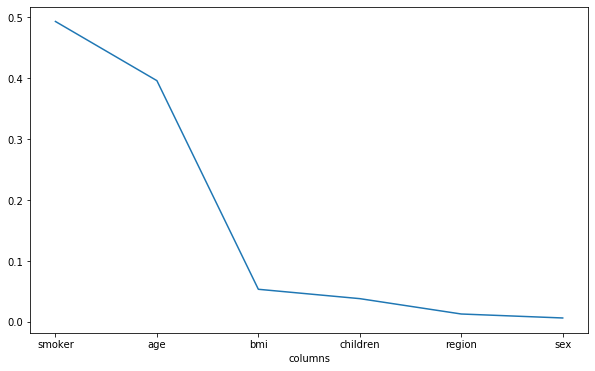

In [48]:
feature_importance.plot('columns', 'importance', figsize=(10,6), legend=False);

In [49]:
def plot_feature_importance(fi): 
    return fi.plot('columns', 'importance', 'barh', figsize=(12,7), legend=False)

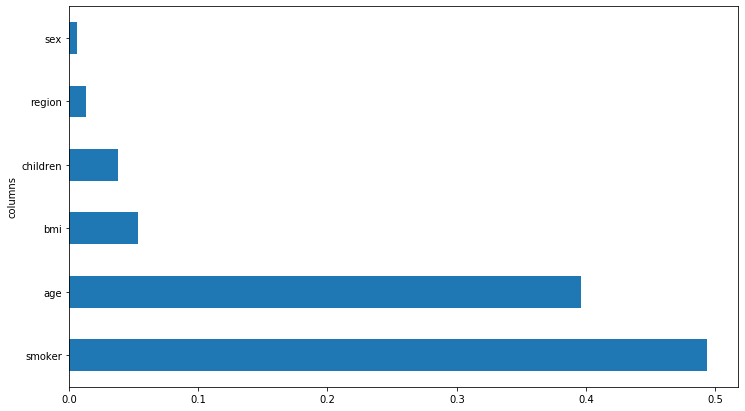

In [50]:
plot_feature_importance(feature_importance);

In [51]:
keep_columns = feature_importance[feature_importance["importance"]>0.01]["columns"]; 
len(keep_columns)

5

In [136]:
df_trn[keep_columns].copy()

,smoker,age,bmi,children,region
0,1,19,27.900,0,3
1,0,18,33.770,1,2
2,0,28,33.000,3,2
3,0,33,22.705,0,1
4,0,32,28.880,0,1
...,...,...,...,...,...
1333,0,50,30.970,3,1
1334,0,18,31.920,0,0
1335,0,18,36.850,0,2
1336,0,21,25.800,0,3


In [150]:
df_keep = df_trn[keep_columns].copy()
x, x_valid = split_vals(df_keep, n_trn)

In [151]:
y, y_valid = split_vals(y_trn, n_trn)

In [152]:
y

array([9.73417643, 7.45330245, 8.40053847, ..., 9.31340106, 8.93899322,
       8.0634684 ])

In [153]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=4, max_features=0.5, n_jobs=-1, oob_score=True, max_depth=7, random_state=42)
%time m.fit(x, y)
print_score(m)

Wall time: 165 ms
RMSLE of train set 0.3359840760038288
RMSLE of validation set 0.37680686932408
R^2 of train set 0.8666132313232057
R^2 of validation set 0.8302338860745265


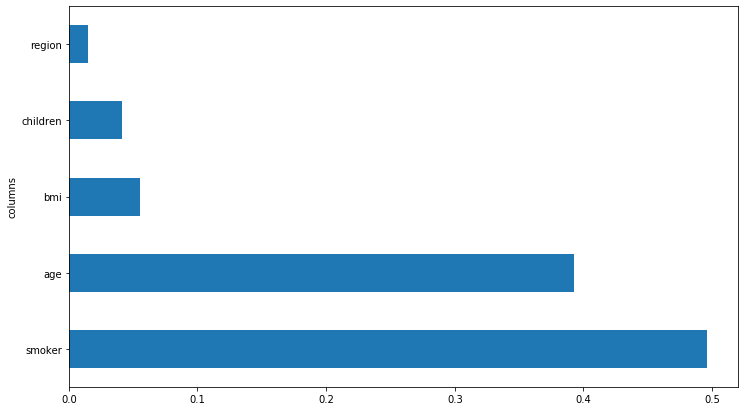

In [56]:
feature_importance = rf_feat_importance(m, df_keep)
plot_feature_importance(feature_importance);

In [57]:
def numericalize(df, col, name, max_cat):
    if not is_numeric_dtype(col) and (max_cat is None or len(col.cat.categories)>max_cat):
        df[name] = pd.Categorical(col).codes

In [58]:
def fix_missing(df, col, name, nan_dict, is_train):
    
    if is_train:
        if is_numeric_dtype(col):
            if pd.isnull(col).sum():
                df[name+"_na"] = pd.isnull(col)
                nan_dict[name] = col.median()
                df[name] = col.fillna(nan_dict[name])
            
            
    else:
        if is_numeric_dtype(col):
            if name in nan_dict:
                df[name+"_na"] = pd.isnull(col)
                df[name] = col.fillna(nan_dict[name])
                
        
            else:
                df[name] = col.fillna(col.median())

In [59]:
def proc_df(df, y_fld,nan_dict=None,is_train=True, max_cat=None):
    
    df = df.copy()
    y = df[y_fld].values
    
    df.drop(y_fld, axis = 1, inplace = True)
    
    if nan_dict is None:
        nan_dict = {}
    
    for n, c in df.items():
        fix_missing(df, c, n,nan_dict, is_train)
        numericalize(df, c, n, max_cat)
        
    df = pd.get_dummies(df, dummy_na=True)
        
    
    return df, y, nan_dict


In [60]:
df_train2, y_train, nan_dict = proc_df(df_raw, 'charges', max_cat=5)

x, x_valid = split_vals(df_train2, n_trn)
y, y_valid = split_vals(y_train, n_trn)

m = RandomForestRegressor(n_estimators=40, min_samples_leaf=4, max_features=0.5, n_jobs=-1, oob_score=True, max_depth=7, random_state=42)
%time m.fit(x, y)
print_score(m)

Wall time: 140 ms
RMSLE of train set 0.3199144430206948
RMSLE of validation set 0.3831892020856008
R^2 of train set 0.8790674925612217
R^2 of validation set 0.8244342041579664


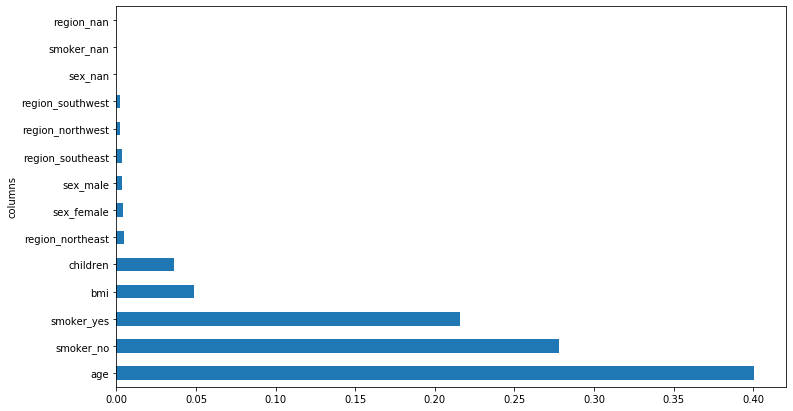

In [61]:
feature_importance = rf_feat_importance(m, df_train2)
plot_feature_importance(feature_importance);

In [62]:
import scipy
from scipy.cluster import hierarchy as hc
from matplotlib import pyplot as plt

In [63]:
scipy.stats.spearmanr(df_keep).correlation

array([[ 1.        , -0.02521046,  0.00220331,  0.01658339, -0.0021548 ],
       [-0.02521046,  1.        ,  0.10773604,  0.05699222,  0.00431528],
       [ 0.00220331,  0.10773604,  1.        ,  0.01560674,  0.15295931],
       [ 0.01658339,  0.05699222,  0.01560674,  1.        ,  0.01060442],
       [-0.0021548 ,  0.00431528,  0.15295931,  0.01060442,  1.        ]])

In [64]:
??hc

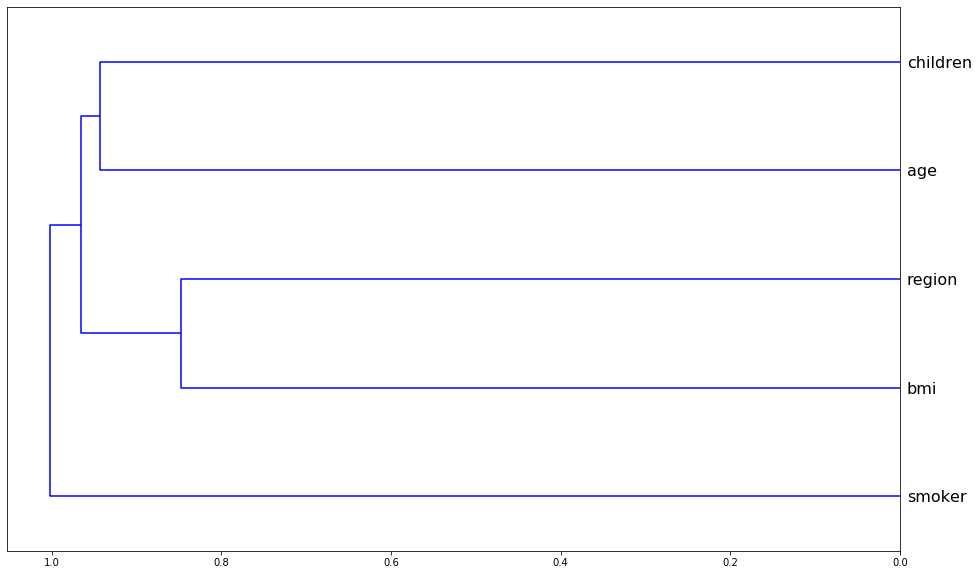

In [65]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

In [66]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=4, max_features=0.5, n_jobs=-1, oob_score=True, max_depth=7, random_state=42)
    x, _ = split_vals(df, n_trn)
    m.fit(x, y)
    return m.oob_score_

In [67]:
get_oob(df_keep)

0.8233110692619788

In [68]:
from pdpbox import pdp
from plotnine import *

In [74]:
df_trn2, y_trn, nas = proc_df(df_raw, 'charges', max_cat=5)
x, x_valid = split_vals(df_trn2, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=4, max_features=0.5, n_jobs=-1, oob_score=True, max_depth=7, random_state=42)
m.fit(x, y);

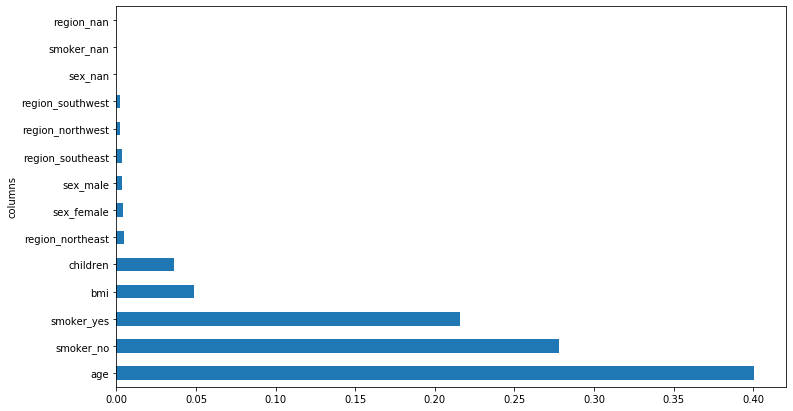

In [75]:
plot_feature_importance(rf_feat_importance(m, df_trn2));

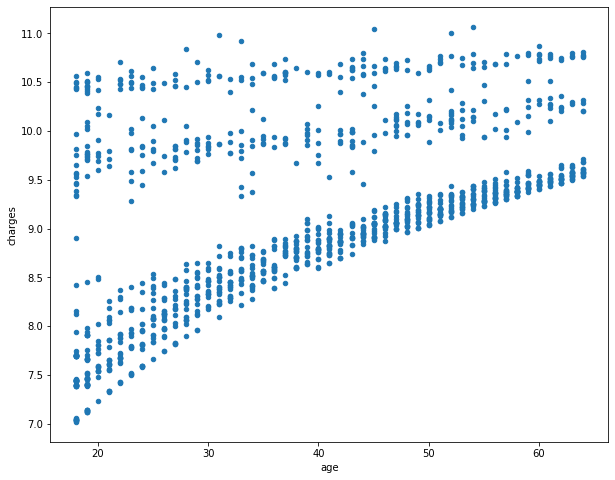

In [79]:
df_raw.plot('age', 'charges', 'scatter', alpha=1, figsize=(10,8));

In [80]:
?? stat_smooth

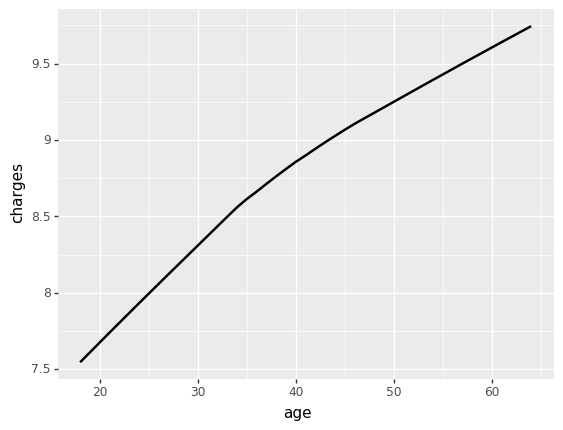

<ggplot: (-9223371846106883688)>

In [82]:
ggplot(df_raw, aes('age', 'charges'))+stat_smooth(se=True, method='lowess' )

In [113]:
def plot_pdp(feat, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(m, x, x.columns, feat)
    return pdp.pdp_plot(p, feat_name, plot_lines=True,
                        cluster=clusters is not None,
                        n_cluster_centers=clusters)

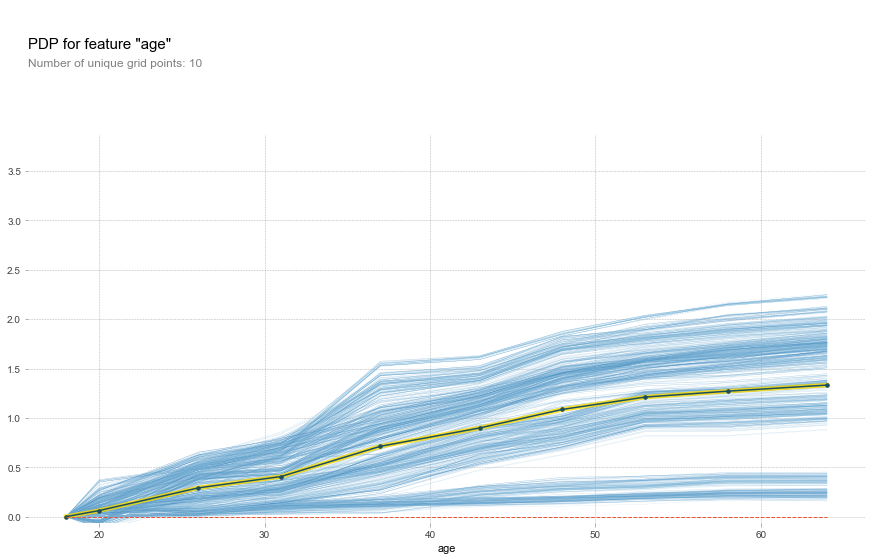

In [114]:
plot_pdp('age');

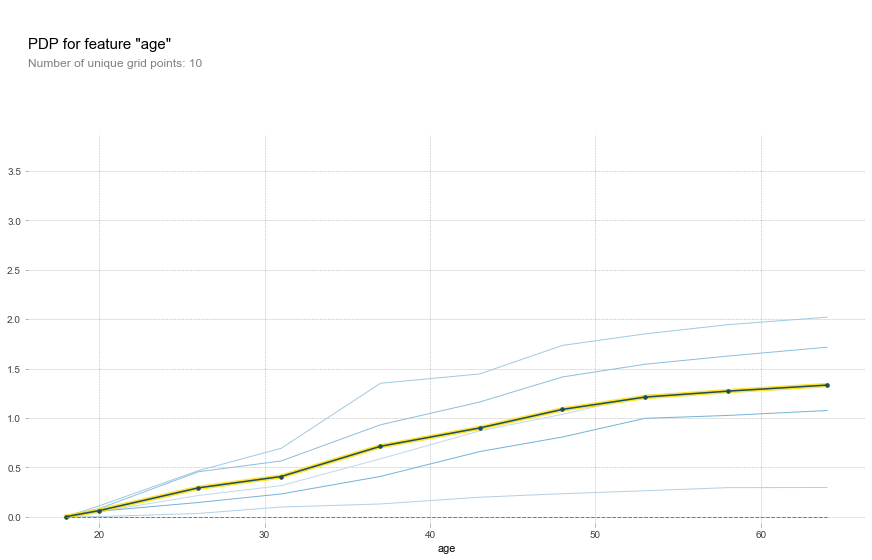

In [87]:
plot_pdp('age', clusters=5);

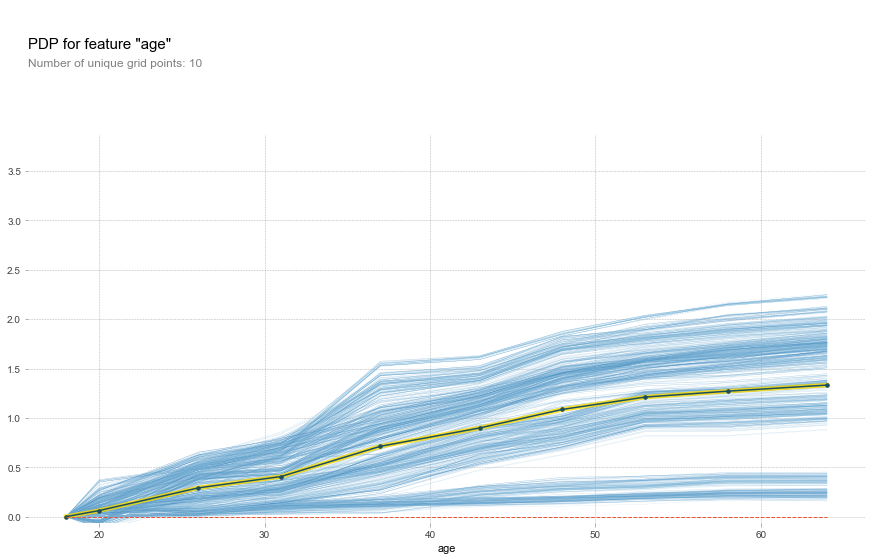

In [88]:
plot_pdp('age');

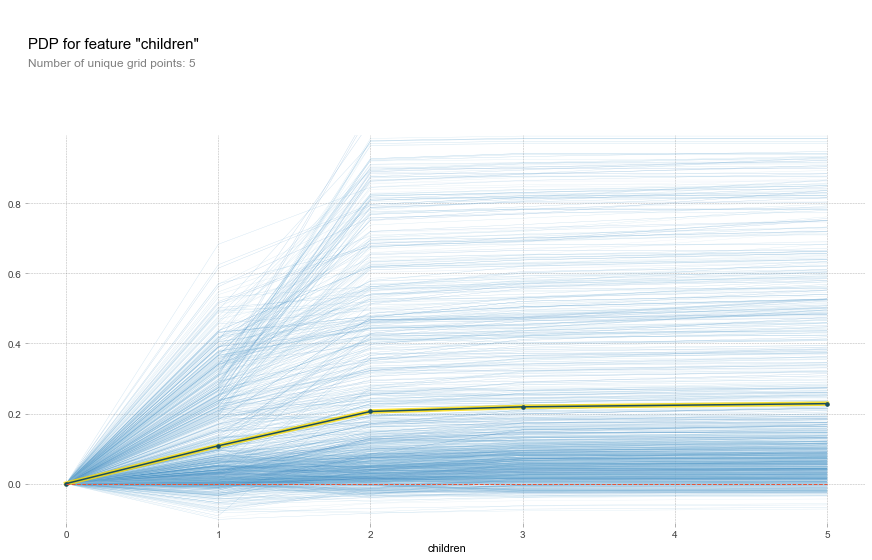

In [90]:
plot_pdp('children');

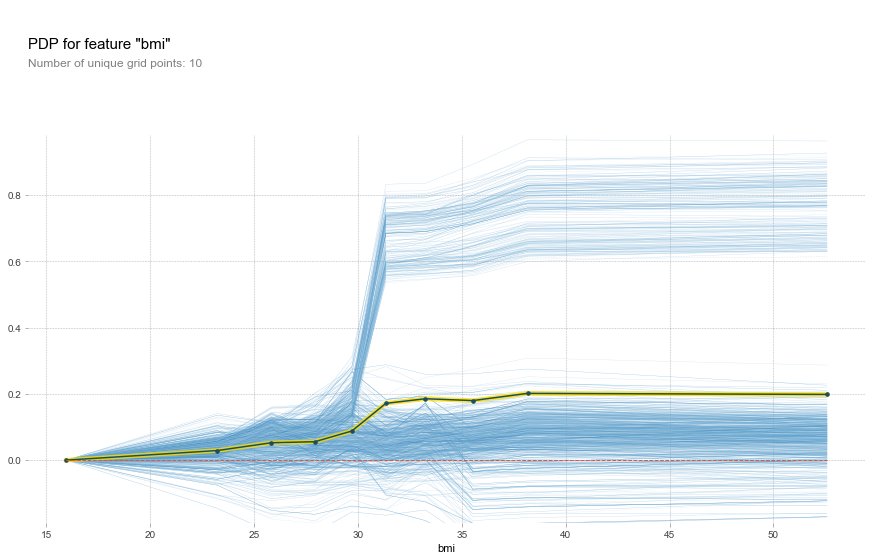

In [91]:
plot_pdp('bmi');

In [89]:
df_raw.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,9.734176
1,18,male,33.770,1,no,southeast,7.453302
2,28,male,33.000,3,no,southeast,8.400538
3,33,male,22.705,0,no,northwest,9.998092
4,32,male,28.880,0,no,northwest,8.260197


TypeError: clabel() got an unexpected keyword argument 'contour_label_fontsize'

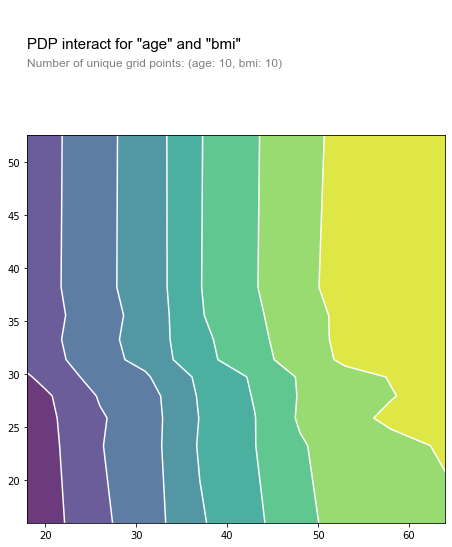

In [95]:
feats = ['age', 'bmi']
p = pdp.pdp_interact(m, x, x.columns, feats)
pdp.pdp_interact_plot(p, feats)

# Tree interpreter

In [117]:
from treeinterpreter import treeinterpreter as ti

In [118]:
df_train, df_valid = split_vals(df_raw[df_keep.columns], n_trn)

In [120]:
x_valid.values

array([[33.  , 30.25,  0.  , ...,  1.  ,  0.  ,  0.  ],
       [19.  , 32.49,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [50.  , 37.07,  1.  , ...,  1.  ,  0.  ,  0.  ],
       ...,
       [18.  , 36.85,  0.  , ...,  1.  ,  0.  ,  0.  ],
       [21.  , 25.8 ,  0.  , ...,  0.  ,  1.  ,  0.  ],
       [61.  , 29.07,  0.  , ...,  0.  ,  0.  ,  0.  ]])

In [121]:
x_valid.values.shape

(200, 14)

In [122]:
# row 0
row = x_valid.values[None,0]; row

array([[33.  , 30.25,  0.  ,  0.  ,  1.  ,  0.  ,  1.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  1.  ,  0.  ,  0.  ]])

In [124]:
prediction, bias, contributions = ti.predict(m, row)

In [125]:
prediction[0], bias[0]

(array([8.57310123]), 9.09794599687537)

In [126]:
contributions.shape

(1, 14)

In [127]:
contributions.shape

(1, 14)

In [133]:
x_valid

,age,bmi,children,sex_female,sex_male,sex_nan,smoker_no,smoker_yes,smoker_nan,region_northeast,region_northwest,region_southeast,region_southwest,region_nan
1138,33,30.25,0,0,1,0,1,0,0,0,0,1,0,0
1139,19,32.49,0,1,0,0,0,1,0,0,1,0,0,0
1140,50,37.07,1,0,1,0,1,0,0,0,0,1,0,0
1141,41,32.60,3,1,0,0,1,0,0,0,0,0,1,0
1142,52,24.86,0,1,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,50,30.97,3,0,1,0,1,0,0,0,1,0,0,0
1334,18,31.92,0,1,0,0,1,0,0,1,0,0,0,0
1335,18,36.85,0,1,0,0,1,0,0,0,0,1,0,0
1336,21,25.80,0,1,0,0,1,0,0,0,0,0,1,0


In [130]:
df_keep.shape

(1338, 5)

In [131]:
[o for o in zip(x_valid.columns, x_valid.iloc[0], contributions[0])]

[('age', 33.0, -0.01054597340572554),
 ('bmi', 30.25, -0.007411787243293211),
 ('children', 0.0, -0.11170858188711426),
 ('sex_female', 0.0, -0.023654774546213408),
 ('sex_male', 1.0, -0.010517615802729275),
 ('sex_nan', 0.0, 0.0),
 ('smoker_no', 1.0, -0.1562258596012373),
 ('smoker_yes', 0.0, -0.14072556169138611),
 ('smoker_nan', 0.0, 0.0),
 ('region_northeast', 0.0, -0.013461809575771855),
 ('region_northwest', 0.0, -0.005122466947705862),
 ('region_southeast', 1.0, -0.05011545238181416),
 ('region_southwest', 0.0, 0.0046451198726222605),
 ('region_nan', 0.0, 0.0)]

In [132]:
[o for o in zip(df_keep.columns, df_valid.iloc[0], contributions[0])]

[('smoker', 'no', -0.01054597340572554),
 ('age', 33, -0.007411787243293211),
 ('bmi', 30.25, -0.11170858188711426),
 ('children', 0, -0.023654774546213408),
 ('region', 'southeast', -0.010517615802729275)]

# Dealing with Extrapolation

In [184]:
df_ext = df_keep.copy()
df_ext['is_valid'] = 1
df_ext.is_valid[:n_trn] = 0
x, y, nas = proc_df(df_ext, 'is_valid')

In [185]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_


0.8482810164424515

In [186]:
fi = rf_feat_importance(m, x)
fi

,columns,importance
2,bmi,0.448077
1,age,0.334585
4,region,0.097869
3,children,0.092129
0,smoker,0.027340


In [187]:
feats=['smoker', 'age',"bmi","region"]

In [188]:
x.drop(feats, axis=1, inplace=True)

In [189]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_


0.8505231689088192

In [190]:
y, y_valid = split_vals(y_trn, n_trn)
x, x_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y)
print_score(m)

RMSLE of train set 0.29405630852579706
RMSLE of validation set 0.38386491373764703
R^2 of train set 0.8978269483577503
R^2 of validation set 0.8238144766167803


In [191]:
for f in feats:
    df_subs = df_keep.drop(f, axis=1)
    x, x_valid = split_vals(df_subs, n_trn)
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(x, y)
    print(f)
    print_score(m)

smoker
RMSLE of train set 0.580335239225258
RMSLE of validation set 0.8131127353047454
R^2 of train set 0.6020456573684339
R^2 of validation set 0.2094762706364882
age
RMSLE of train set 0.5249754665389562
RMSLE of validation set 0.6079922503617685
R^2 of train set 0.6743482778132477
R^2 of validation set 0.5580130245146508
bmi
RMSLE of train set 0.34181062791876077
RMSLE of validation set 0.40596985136592256
R^2 of train set 0.8619467970370298
R^2 of validation set 0.8029388786795302
region
RMSLE of train set 0.298488928038347
RMSLE of validation set 0.40228498424017
R^2 of train set 0.8947234084946325
R^2 of validation set 0.806499973420589


In [193]:
df_subs = df_keep.copy()
x, x_valid = split_vals(df_subs, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y)
print_score(m)

RMSLE of train set 0.2915344584246072
RMSLE of validation set 0.3635606743654368
R^2 of train set 0.8995719219222202
R^2 of validation set 0.8419599403208549


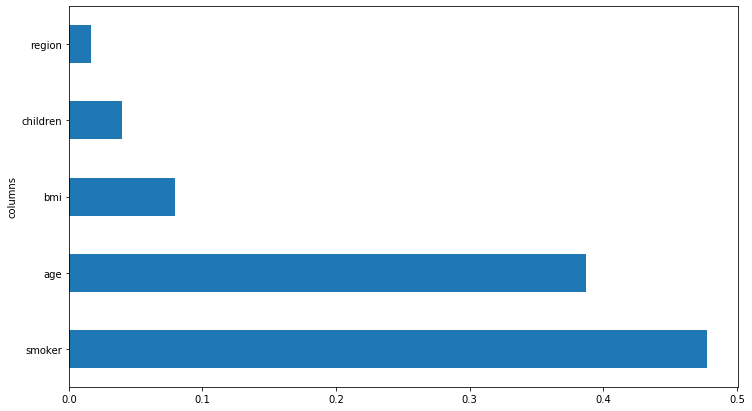

In [194]:
plot_feature_importance(rf_feat_importance(m, x));